##### Test by independent Gillespie simulation

In [1]:
import memo_py as me
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pickle
import copy
import scipy.stats as stats

/Users/mlanghinrichs/Documents/Studium/MSc/09_hiwi_hoefer/01_project/memo_py/memo_py/selection.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


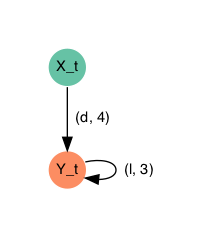

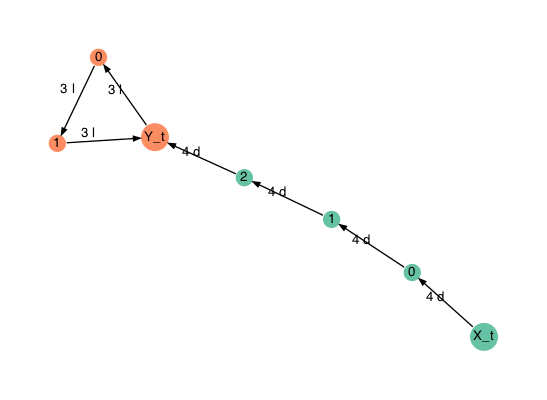

In [2]:
# test is based on the following specific network
t = [
    {'start': 'X_t', 'end': 'Y_t', 'rate_symbol': 'd', 'type': 'S -> E', 'reaction_steps': 4},
    {'start': 'Y_t', 'end': 'Y_t', 'rate_symbol': 'l', 'type': 'S -> S + S', 'reaction_steps': 3}
    ]

net = me.Network('net_test_1')
net.structure(t)

me.plots.net_main_plot(net)
me.plots.net_hidden_plot(net)

##### Gillespie simulations (independent / framework external)

In [3]:
def gill_indep_test_1(initial_state, time_values, d, l, num_iter):
    # initialisation
    res = np.zeros((num_iter, 7, time_values.shape[0]))
    
    for i in range(num_iter):
        time_current = time_values[0]
        time_max = time_values[-1]
        cell_state = np.zeros(7)
        cell_state = copy.deepcopy(initial_state)
        
#         print('iter: ', i)
#         print('time_current: ', time_current)
#         print('time_max: ', time_max)
#         print('cell_state: ', cell_state)
        
        while time_current <= time_max:
            # reaction propensities
            reac_props = np.array([
                4.0 * d * cell_state[0], # d from Xcentric to X0
                4.0 * d * cell_state[1], # d from X0 to X1
                4.0 * d * cell_state[2], # d from X1 to X2
                4.0 * d * cell_state[3], # d from X2 to Ycentric
                3.0 * l * cell_state[4], # l from Ycentric to Y0
                3.0 * l * cell_state[5], # l from Y0 to Y1
                3.0 * l * cell_state[6], # l from Y1 to Ycentric
            ])
#             print('\n while start')
#             print('reac_props: ', reac_props)

            # draw exponential random time for next reaction
            total_prop = np.sum(reac_props)
            dt = np.random.exponential(1.0/total_prop)
            
#             print('total_prop: ', total_prop)
#             print('dt: ', dt)

            # save cell state results for relevant time points
            for ind in np.where((time_values >= time_current) 
                                & (time_values < time_current + dt))[0]:
                res[i, :, ind] = copy.deepcopy(cell_state).reshape((1,7))
            
#             print('res: ', res)
            
            # draw which reaction takes place
            reac_probs = reac_props/np.sum(reac_props)
            reac_rand = np.random.choice(reac_props.shape[0], p=reac_probs)
            
#             print('reac_probs: ', reac_probs)
#             print('reac_rand: ', reac_rand)

            # update cell state according to selected reaction
            # differentiation
            if reac_rand==0:
                cell_state[0] += -1.0
                cell_state[1] += +1.0
            elif reac_rand==1:
                cell_state[1] += -1.0
                cell_state[2] += +1.0
            elif reac_rand==2:
                cell_state[2] += -1.0
                cell_state[3] += +1.0
            elif reac_rand==3:
                cell_state[3] += -1.0
                cell_state[4] += +1.0

            # division
            elif reac_rand==4:
                cell_state[4] += -1.0
                cell_state[5] += +1.0
            elif reac_rand==5:
                cell_state[5] += -1.0
                cell_state[6] += +1.0
            elif reac_rand==6:
                cell_state[6] += -1.0
                cell_state[4] += +2.0
            else:
                print('error')

            # update current time by delta t
            time_current += dt
            
#             print('cell_state: ', cell_state)
#             print('time_current: ', time_current)
#             print('\n')
    
    # sum hidden states to get observable layer
    res_obs = np.zeros((num_iter, 2, time_values.shape[0]))
    res_obs[:, 0, :] = np.sum(res[:, (0,1,2,3), :], axis=1)
    res_obs[:, 1, :] = np.sum(res[:, (4,5,6), :], axis=1)
    return res_obs

In [4]:
# order of the variables of the hidden layer
# X centric, X diff 0, X diff 1, X diff 2, Y centric, Y div 0, Y div 1
initial_values = np.array([1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
time_values = np.linspace(0.0, 54.0, num=28, endpoint=True)
d = 0.04
l = 0.06
num_iter = 50000
print(time_values)

# save result as external simulation results
sim_res_ext = gill_indep_test_1(initial_values, time_values, d, l, num_iter)

[ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18. 20. 22. 24. 26. 28. 30. 32. 34.
 36. 38. 40. 42. 44. 46. 48. 50. 52. 54.]


In [5]:
print(sim_res_ext.shape)

(50000, 2, 28)


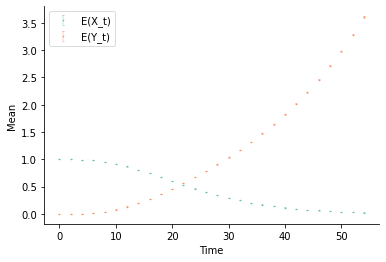

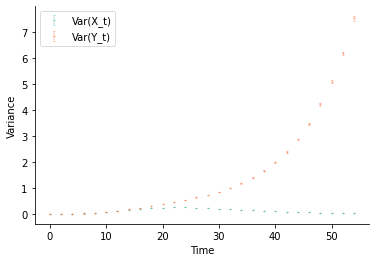

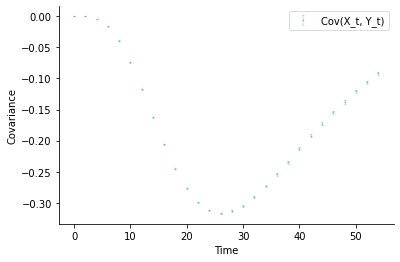

In [6]:
data_ext = me.Data('data_test_1_external')
data_ext.load(['X_t', 'Y_t'], time_values, sim_res_ext, 
              bootstrap_samples=1000, basic_sigma=1/num_iter)

me.plots.data_mean_plot(data_ext)
me.plots.data_variance_plot(data_ext)
me.plots.data_covariance_plot(data_ext)

##### Gillespie simulations (framework)

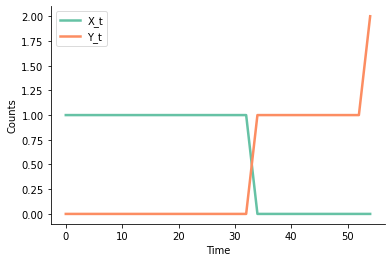

In [7]:
# compute Gillespie simulation with the framework
t = [
    {'start': 'X_t', 'end': 'Y_t', 'rate_symbol': 'd', 'type': 'S -> E', 'reaction_steps': 4},
    {'start': 'Y_t', 'end': 'Y_t', 'rate_symbol': 'l', 'type': 'S -> S + S', 'reaction_steps': 3}
    ]

initial_values = {'X_t': 1, 'Y_t': 0}
theta_values = {'l': 0.06, 'd': 0.04}
time_values = np.linspace(0.0, 54.0, num=28, endpoint=True)
variables = {'X_t': ('X_t', ), 'Y_t': ('Y_t', )}

net = me.Network('net_test_1')
net.structure(t)

sim = me.Simulation(net)
res = sim.simulate('gillespie', variables, initial_values, theta_values, time_values)

me.plots.sim_counts_plot(sim)

In [8]:
# create a data object from simulations for the estimation
num_iter = 10000

res_list = list()
for __ in range(num_iter):
    res_list.append(sim.simulate('gillespie', variables, initial_values, theta_values, time_values)[1])

sim_res_int = np.array(res_list)

In [9]:
sim_res_int.shape

(10000, 2, 28)

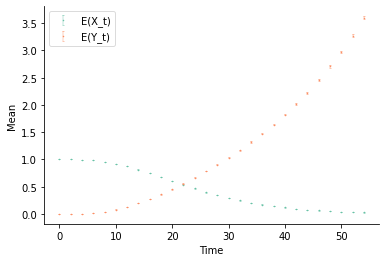

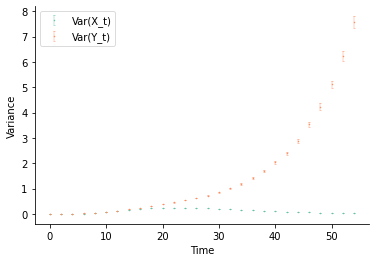

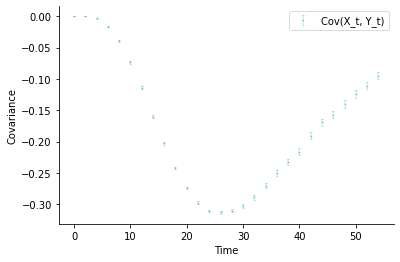

In [10]:
data_int = me.Data('data_test_1_internal')
data_int.load(['X_t', 'Y_t'], time_values, sim_res_int, 
              bootstrap_samples=1000, basic_sigma=1/num_iter)

me.plots.data_mean_plot(data_int)
me.plots.data_variance_plot(data_int)
me.plots.data_covariance_plot(data_int)

##### Moment simulations (framework)

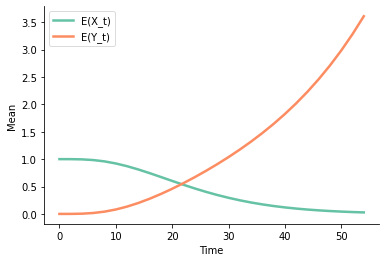

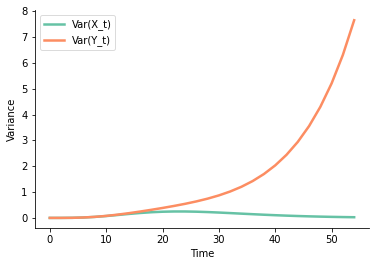

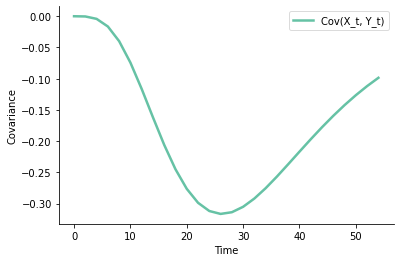

In [11]:
t = [
    {'start': 'X_t', 'end': 'Y_t', 'rate_symbol': 'd', 'type': 'S -> E', 'reaction_steps': 4},
    {'start': 'Y_t', 'end': 'Y_t', 'rate_symbol': 'l', 'type': 'S -> S + S', 'reaction_steps': 3}
    ]

initial_values = {'X_t': 1, 'Y_t': 0}
theta_values = {'l': 0.06, 'd': 0.04}
time_values = np.linspace(0.0, 54.0, num=28, endpoint=True)
variables = {'X_t': ('X_t', ), 'Y_t': ('Y_t', )}

net = me.Network('net_test_1')
net.structure(t)

sim = me.Simulation(net)
res = sim.simulate('moments', variables, initial_values, theta_values, time_values)

me.plots.sim_mean_plot(sim)
me.plots.sim_variance_plot(sim)
me.plots.sim_covariance_plot(sim)

##### Models for estimation

In [8]:
def make_net(steps_d, steps_l):
    name = 'net_' + str(steps_d) + '_' + str(steps_l)

    t = [
    {'start': 'X_t', 'end': 'Y_t', 'rate_symbol': 'd', 'type': 'S -> E', 'reaction_steps': steps_d},
    {'start': 'Y_t', 'end': 'Y_t', 'rate_symbol': 'l', 'type': 'S -> S + S', 'reaction_steps': steps_l}
    ]

    net = me.Network(name)
    net.structure(t)

    return net

nets = [make_net(steps_d, steps_l) for steps_d in range(1, 6) for steps_l in range(1, 6)]
print(len(nets))

25


##### Estimation of internal simulated data

In [13]:
variables = [{'X_t': ('X_t', ), 'Y_t': ('Y_t', )}]*len(nets)
initial_values = [{'X_t': 1.0, 'Y_t': 0.0}]*len(nets)
theta_bounds = [{'d': (0.0, 0.15), 'l': (0.0, 0.15)}]*len(nets)
            
est_res_int = me.select_models(nets, variables, initial_values, 
                               theta_bounds, data_int)

17


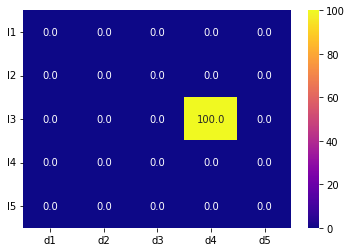

In [14]:
net_names = [est.net.net_name for est in est_res_int]
model_probs = me.selection.compute_model_probabilities(est_res_int)
print(net_names.index('net_4_3'))

steps_lambda = range(1, 6)
steps_alpha = range(1, 6)
rows = [f'l{i}' for i in steps_lambda]
cols = [f'd{i}' for i in steps_alpha]

model_probs_2d = np.zeros((len(rows), len(cols)))

for i, row_step in enumerate(rows):
    for j, col_step in enumerate(cols):
        name = f'net_{steps_alpha[j]}_{steps_lambda[i]}'
        net_index = net_names.index(name)
        model_probs_2d[i, j] = model_probs[net_index]

df = pd.DataFrame(model_probs_2d * 100.0, index=rows, columns=cols)

plt.figure(figsize=(6, 4)) # 8, 4 or 6, 8
sns.heatmap(df, cmap='plasma', annot=True, fmt='.1f') # annot=True
plt.yticks(rotation=0, va='center')
plt.show()

In [15]:
df

,d1,d2,d3,d4,d5
l1,0.0,0.0,0.0,0.000000e+00,0.0
l2,0.0,0.0,0.0,3.641800e-175,0.0
l3,0.0,0.0,0.0,1.000000e+02,0.0
l4,0.0,0.0,0.0,7.374783e-27,0.0
l5,0.0,0.0,0.0,8.418100e-93,0.0


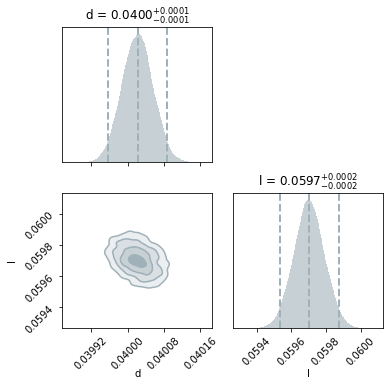

In [16]:
est = est_res_int[17]
me.plots.est_corner_kernel_plot(est)

##### Estimation of external simulated data

In [10]:
variables = [{'X_t': ('X_t', ), 'Y_t': ('Y_t', )}]*len(nets)
initial_values = [{'X_t': 1.0, 'Y_t': 0.0}]*len(nets)
theta_bounds = [{'d': (0.0, 0.15), 'l': (0.0, 0.15)}]*len(nets)
            
est_res_ext = me.select_models(nets, variables, initial_values, 
                               theta_bounds, data_ext, parallel=False)

In [13]:
est = est_res_ext[17]
est

In [14]:
est = est_res_ext[17]
model_evids = [est.bay_est_log_evidence for est in est_res_ext]
model_evids

[-2085898.78498476,
 -2035235.7652672064,
 -2026982.1343909553,
 -2025669.2536063832,
 -2025837.4519475223,
 -292868.2531714183,
 -251085.7650534302,
 -239670.7369353134,
 -235199.3154122396,
 -233070.89240709168,
 -59939.47420917303,
 -32555.491329858865,
 -26553.20070142983,
 -24872.480763215364,
 -24448.306623808876,
 -18704.285473553275,
 -1278.4646469441252,
 718.5764768714287,
 259.5878559348308,
 -645.1093395729347,
 -19588.93795279499,
 -9021.186473690314,
 -9831.348937500668,
 -11811.122555529377,
 -13669.078834902613]

In [15]:
# read out evidence list
logevids = np.array([est.bay_est_log_evidence for est in est_res_ext])

# due to overflow cut off very high evidences (wont change result much)
logevids[logevids > 700.0] = 700
print(logevids)

# log model prior (log of model number)
# assuming uniform model prior
logmprior = - np.log(logevids.shape[0])

# calculate normalising factor p(D)
logpdata = np.log(np.sum(np.exp(logevids))) + logmprior

# calculate model probabilities
model_probs = np.exp(logevids + logmprior - logpdata)
model_probs

[-2.08589878e+06 -2.03523577e+06 -2.02698213e+06 -2.02566925e+06
 -2.02583745e+06 -2.92868253e+05 -2.51085765e+05 -2.39670737e+05
 -2.35199315e+05 -2.33070892e+05 -5.99394742e+04 -3.25554913e+04
 -2.65532007e+04 -2.48724808e+04 -2.44483066e+04 -1.87042855e+04
 -1.27846465e+03  7.00000000e+02  2.59587856e+02 -6.45109340e+02
 -1.95889380e+04 -9.02118647e+03 -9.83134894e+03 -1.18111226e+04
 -1.36690788e+04]


array([0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 1.00000000e+000, 5.38810523e-192, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000])

17


(array([0.5, 1.5, 2.5, 3.5, 4.5]), <a list of 5 Text major ticklabel objects>)

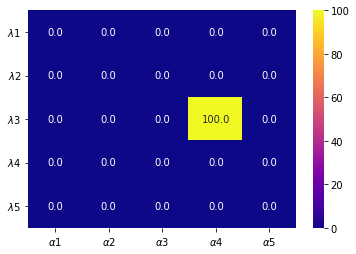

In [16]:
net_names = [est.net.net_name for est in est_res_ext]
# model_probs = me.selection.compute_model_probabilities(est_res_ext)
print(net_names.index('net_4_3'))

steps_lambda = range(1, 6)
steps_alpha = range(1, 6)
rows = [fr'$\lambda{i}$' for i in steps_lambda]
cols = [fr'$\alpha{i}$' for i in steps_alpha]

model_probs_2d = np.zeros((len(rows), len(cols)))

for i, row_step in enumerate(rows):
    for j, col_step in enumerate(cols):
        name = f'net_{steps_alpha[j]}_{steps_lambda[i]}'
        net_index = net_names.index(name)
        model_probs_2d[i, j] = model_probs[net_index]

df = pd.DataFrame(model_probs_2d * 100.0, index=rows, columns=cols)

plt.figure(figsize=(6, 4)) # 8, 4 or 6, 8
sns.heatmap(df, cmap='plasma', annot=True, fmt='.1f') # annot=True
plt.yticks(rotation=0, va='center')

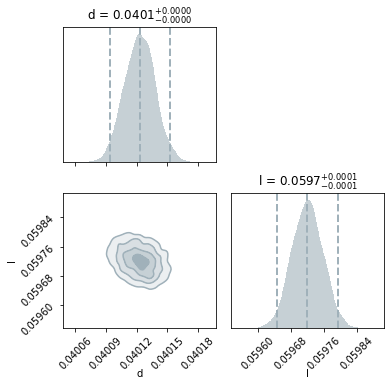

In [17]:
est = est_res_ext[17]
me.plots.est_corner_kernel_plot(est)

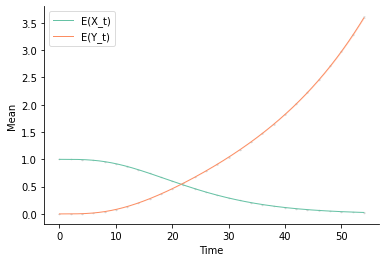

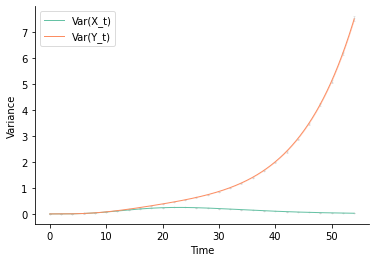

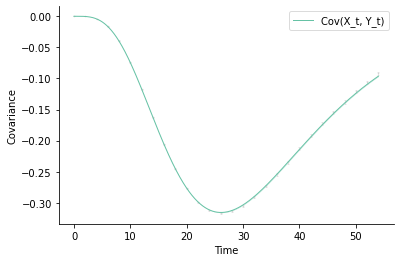

In [18]:
est = est_res_ext[17]
me.plots.est_bestfit_mean_plot(est)
me.plots.est_bestfit_variance_plot(est)
me.plots.est_bestfit_covariance_plot(est)